In [1]:
%run ./PPS_Expansion_Model.ipynb

/home/renato-paredes/.virtualenvs/gifted/lib/python3.13/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


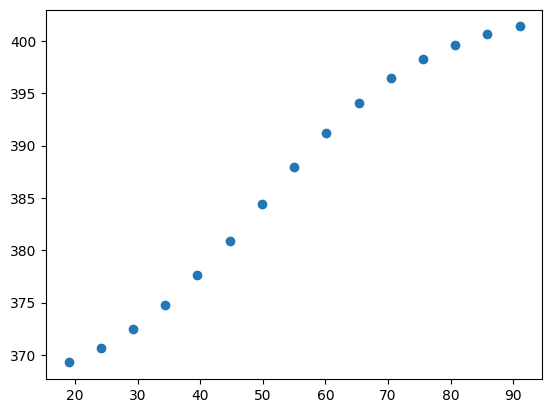

In [2]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
s_distances_sec = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
a_distances = 100 - s_distances_sec * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###SCZ
ymin = 366
ymax = 403
scz_cp = 100 - 1.666 * 30
scz_slope = 1 / 0.075

SCZ_RTs = RTsig(a_distances, scz_cp, scz_slope)
plt.scatter(a_distances, SCZ_RTs)

In [8]:
from scipy.optimize import differential_evolution

HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=1.289e01,
    k2=7.552e02,
    lim=3.674e01,
    alpha=9.797e-01,
)


def sczmodelrun(theta):
    SCZLt, SCZLa, SCZLv = Lw(
        Lex_t=theta[0],
        Lin_t=0.05,
        sigmaex_t=1,
        sigmain_t=4,
        Lex_a=theta[0],
        Lin_a=0.05,
        sigmaex_a=20,
        sigmain_a=80,
        Lex_v=theta[0],
        Lin_v=0.05,
        sigmaex_v=1,
        sigmain_v=4,
    )
    _, _, _, _, SCZrt = experiment(
        ts=ts,
        T=simtime,
        dist=a_distances,
        ya=5,
        Lt=SCZLt,
        La=SCZLa,
        Lv=SCZLv,
        Wt=HCWt,
        Wa=HCWa,
        Wv=HCWv,
        Bt=HCBt,
        Ba=HCBa,
        Bv=HCBv,
        Wat=HCWat,
        Wvt=HCWvt,
        Wav=HCWav,
        FWpr=0,
        CMpr=0,
    )

    SCZ_Model_RTs = fit_RT(xf=SCZrt, yf=SCZ_RTs)
    cost = np.sum(np.square(np.divide(SCZ_RTs - (SCZ_Model_RTs), SCZ_RTs)))

    return cost * 100000


bounds = [(0, 3)]
sczres = differential_evolution(
    sczmodelrun, bounds, disp=True, workers=30, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 17.62656359632009
differential_evolution step 2: f(x)= 17.62656359632009
differential_evolution step 3: f(x)= 17.55053609085897
differential_evolution step 4: f(x)= 17.55053609085897
differential_evolution step 5: f(x)= 17.55053609085897
differential_evolution step 6: f(x)= 16.631592052946576
differential_evolution step 7: f(x)= 16.631592052946576
differential_evolution step 8: f(x)= 16.631592052946576
differential_evolution step 9: f(x)= 16.631592052946576
differential_evolution step 10: f(x)= 16.631592052946576
differential_evolution step 11: f(x)= 16.631592052946576
differential_evolution step 12: f(x)= 16.631592052946576
differential_evolution step 13: f(x)= 16.631592052946576
differential_evolution step 14: f(x)= 16.631592052946576
differential_evolution step 15: f(x)= 16.631592052946576
differential_evolution step 16: f(x)= 16.631592052946576
differential_evolution step 17: f(x)= 16.631592052946576
differential_evolution step 18: f(x)= 16.6315

In [10]:
print(sczres)

             message: Optimization terminated successfully.
             success: True
                 fun: 16.448304910515507
                   x: [ 1.987e+00]
                 nit: 32
                nfev: 495
          population: [[ 1.987e+00]
                       [ 1.988e+00]
                       ...
                       [ 1.988e+00]
                       [ 1.988e+00]]
 population_energies: [ 1.645e+01  1.645e+01 ...  1.645e+01  1.645e+01]


In [3]:
## Fitted model
Lex = 1.987e00

SCZLt, SCZLa, SCZLv = Lw(
    Lex_t=Lex,
    Lin_t=0.05,
    sigmaex_t=1,
    sigmain_t=4,
    Lex_a=Lex,
    Lin_a=0.05,
    sigmaex_a=20,
    sigmain_a=80,
    Lex_v=Lex,
    Lin_v=0.05,
    sigmaex_v=1,
    sigmain_v=4,
)
HCWat, HCWvt, HCWav = cross_modal(at=0.05, sigat=2, vt=0.05, sigvt=2, av=0.05, sigav=2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    Wt_0=6.5,
    Wa_0=6.5,
    Wv_0=6.5,
    Bt_0=2.5,
    Ba_0=2.5,
    Bv_0=2.5,
    k1=1.289e01,
    k2=7.552e02,
    lim=3.674e01,
    alpha=9.797e-01,
)

_, _, _, _, SCZ_Model_RTs = experiment(
    ts=ts,
    T=simtime,
    dist=a_distances,
    ya=5,
    Lt=SCZLt,
    La=SCZLa,
    Lv=SCZLv,
    Wt=HCWt,
    Wa=HCWa,
    Wv=HCWv,
    Bt=HCBt,
    Ba=HCBa,
    Bv=HCBv,
    Wat=HCWat,
    Wvt=HCWvt,
    Wav=HCWav,
    FWpr=0,
    CMpr=0,
)

SCZ_Model_RTs_scaled = fit_RT(xf=SCZ_Model_RTs, yf=SCZ_RTs)

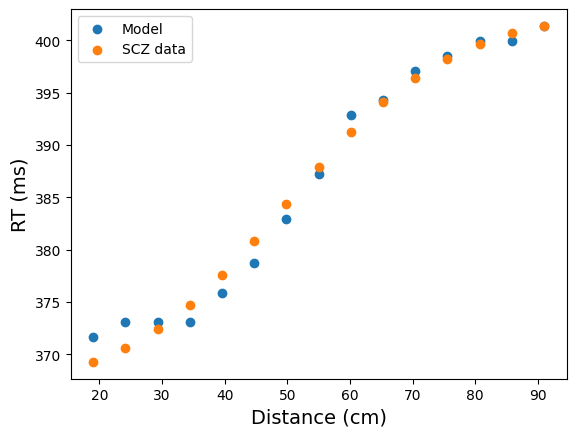

In [4]:
plt.scatter(a_distances, SCZ_Model_RTs_scaled, label="Model")
plt.scatter(a_distances, SCZ_RTs, label="SCZ data")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()

In [10]:
scz_error = calculate_adj_rmse(SCZ_Model_RTs_scaled, SCZ_RTs, 3)
print(scz_error)

1.5456920496492241
